# Make drizzled tiles

There are functionality for defining a tiling grid for a particular field and functions on EC2 to drizzle the tiles in parallel.

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import astropy.time

from grizli.aws import db
from grizli import utils

Set ROOT_PATH=/workspaces/panoramic-jwst/Notebooks


In [2]:
if os.path.exists('/workspaces/panoramic-jwst/Mosaics'):
    os.chdir('/workspaces/panoramic-jwst/Mosaics')

os.getcwd()

'/workspaces/panoramic-jwst/Mosaics'

In [3]:
# Query for tiles

if 1:
    # PANORAMIC
    fields = "AND field like 'panoramic%%'"
    prog = "AND e.dataset like 'jw02514%%'"

instruments = "'NIRCAM','MIRI','NIRISS'"

filters = "'F090W-CLEAR','F115W-CLEAR','F150W-CLEAR','F200W-CLEAR','F277W-CLEAR','F356W-CLEAR','F410M-CLEAR','F444W-CLEAR','F770W','F1800W'"

# filters = "'F410M-CLEAR'"

res = db.SQL(f"""select file, assoc, instrume, filter, tile, field, e.footprint, t.footprint as tile_footprint
from exposure_files e, combined_tiles t
where instrume in ({instruments})
{fields}
AND polygon(e.footprint) && polygon(t.footprint)
{prog} AND e.filter in ({filters})
AND expstart > {astropy.time.Time.now().mjd-360}
""")

len(res)

4491

In [11]:
# Query counting by exposures per field
# can take a while

fields = ','.join([f"'{f}'" for f in np.unique(res['field']).tolist()])
instruments = ','.join([f"'{f}'" for f in np.unique(res['instrume']).tolist()])
filters = ','.join([f"'{f}'" for f in np.unique(res['filter']).tolist()])
prog = ''

grp = db.SQL(f"""select field, tile, instrume, filter, count(filter) as ndrizim
from exposure_files e, combined_tiles t
where instrume in ({instruments})
AND t.field in ({fields})
AND polygon(e.footprint) && polygon(t.footprint)
{prog}
AND e.filter in ({filters})
group by field, tile, instrume, filter
order by field, tile, instrume, filter
""")
grp

field,tile,instrume,filter,ndrizim
str22,str5,str6,str11,int64
panoramic-j090000p0207,08.09,NIRCAM,F115W-CLEAR,16
panoramic-j090000p0207,08.09,NIRCAM,F150W-CLEAR,16
panoramic-j090000p0207,08.09,NIRCAM,F356W-CLEAR,4
panoramic-j090000p0207,08.09,NIRCAM,F444W-CLEAR,4
panoramic-j090000p0207,08.10,NIRCAM,F115W-CLEAR,20
panoramic-j090000p0207,08.10,NIRCAM,F150W-CLEAR,20
panoramic-j090000p0207,08.10,NIRCAM,F356W-CLEAR,4
panoramic-j090000p0207,08.10,NIRCAM,F444W-CLEAR,4
panoramic-j090000p0207,08.11,NIRCAM,F115W-CLEAR,8


   N  value     
====  ==========
 108  panoramic-j145652p2444
 183  panoramic-j100736p2109
 208  panoramic-j090000p0207
 224  panoramic-j093452p6116
 324  panoramic-j131432p2432
 327  panoramic-j093144p0819
 348  panoramic-j094232p0923
 348  panoramic-j134348p5549
 351  panoramic-j170720p5853
 372  panoramic-j121932p0330
 456  panoramic-j150604p5409
 618  panoramic-j153500p2325
 624  panoramic-j125652p5652


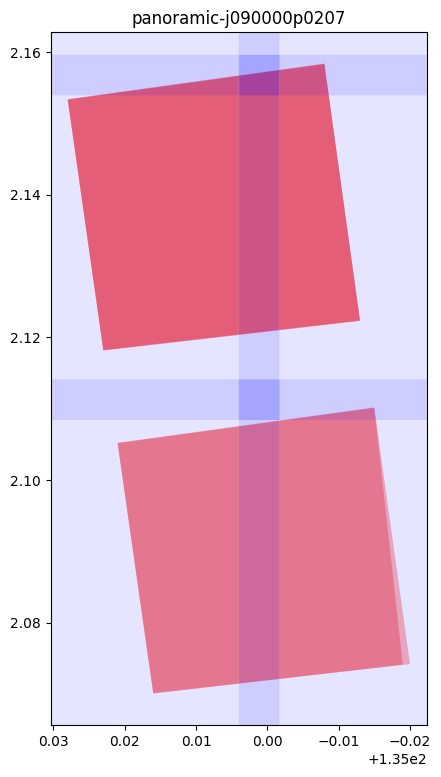

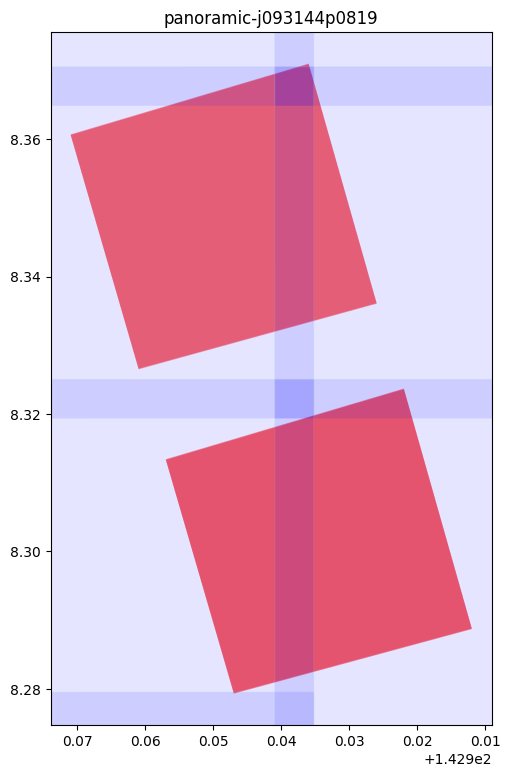

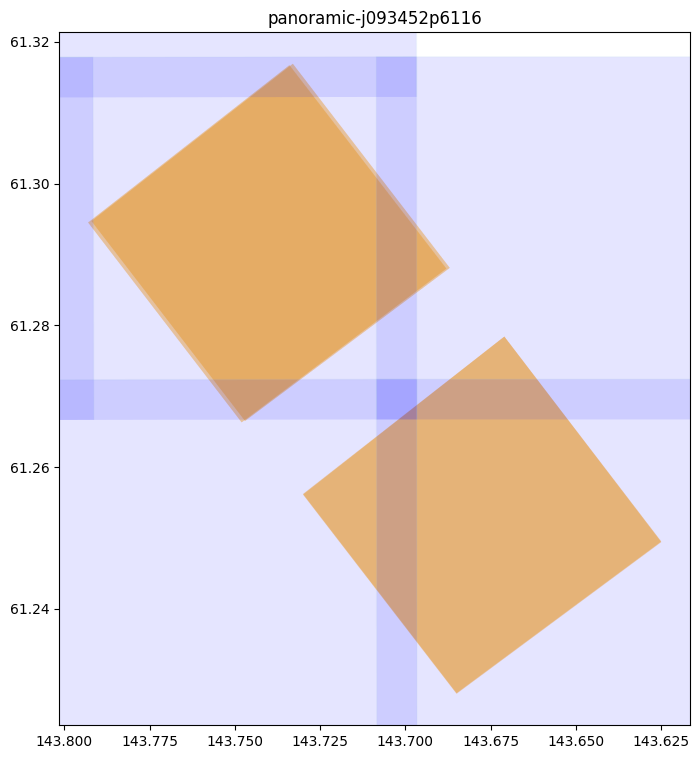

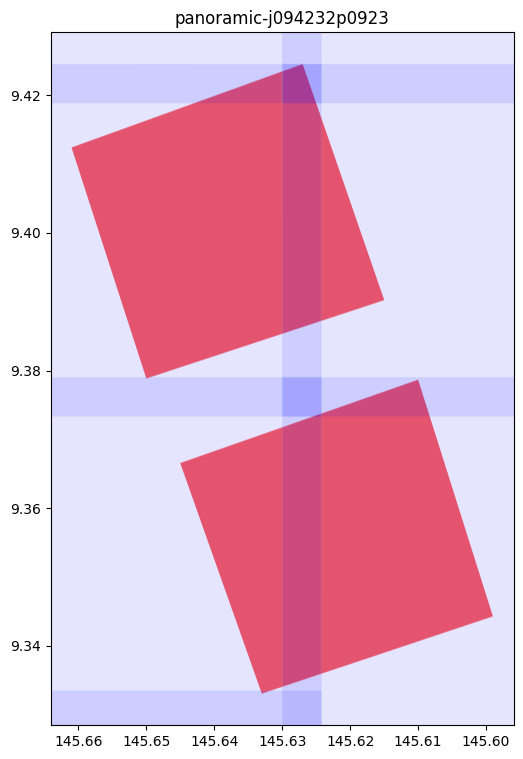

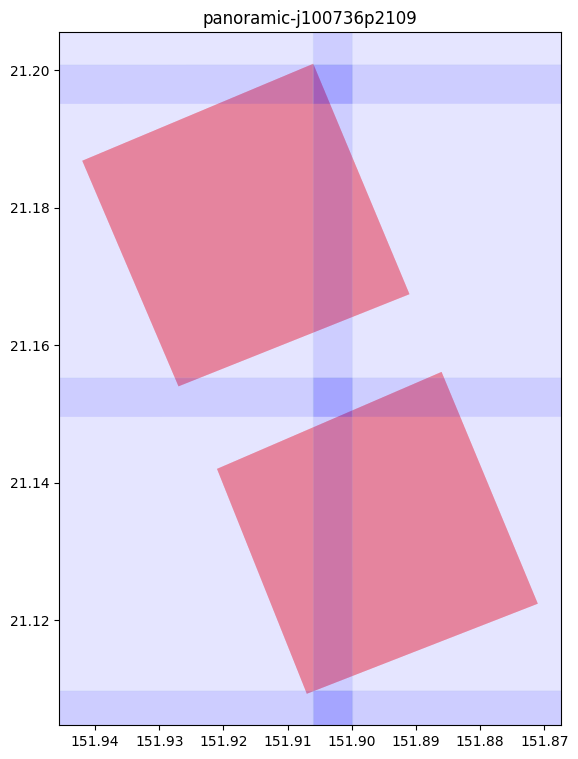

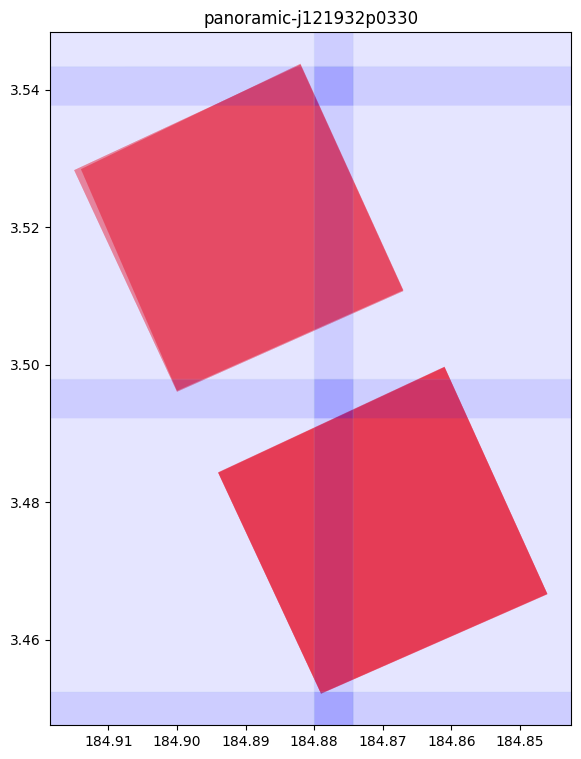

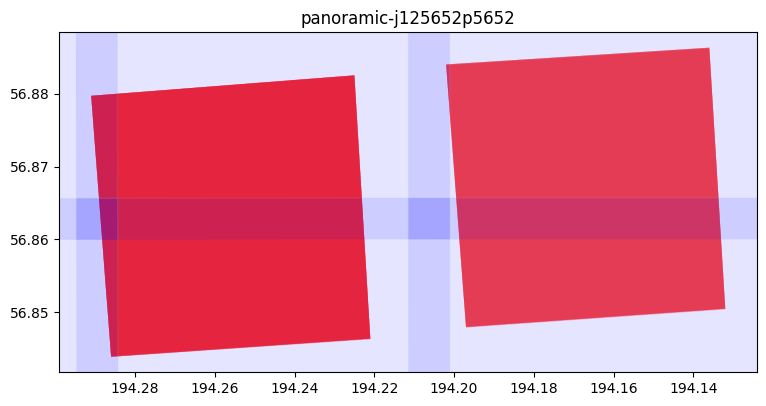

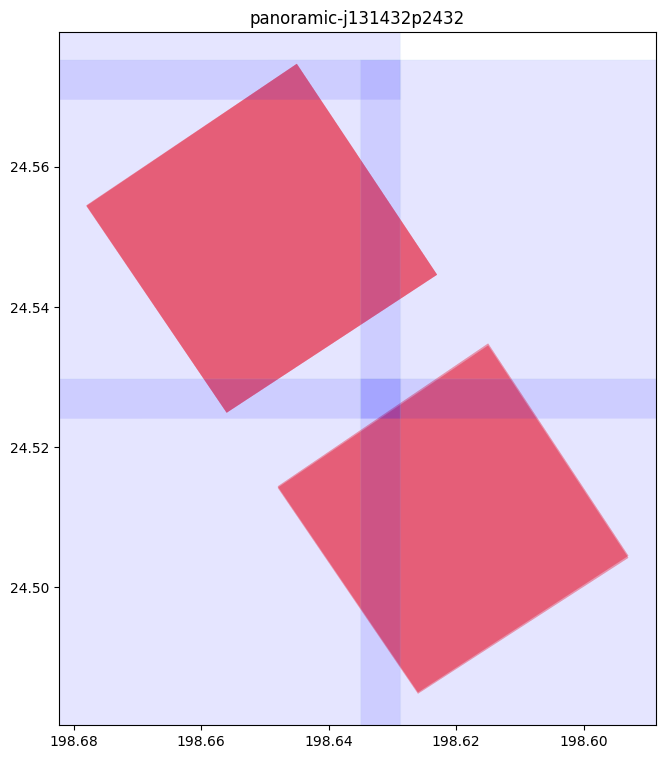

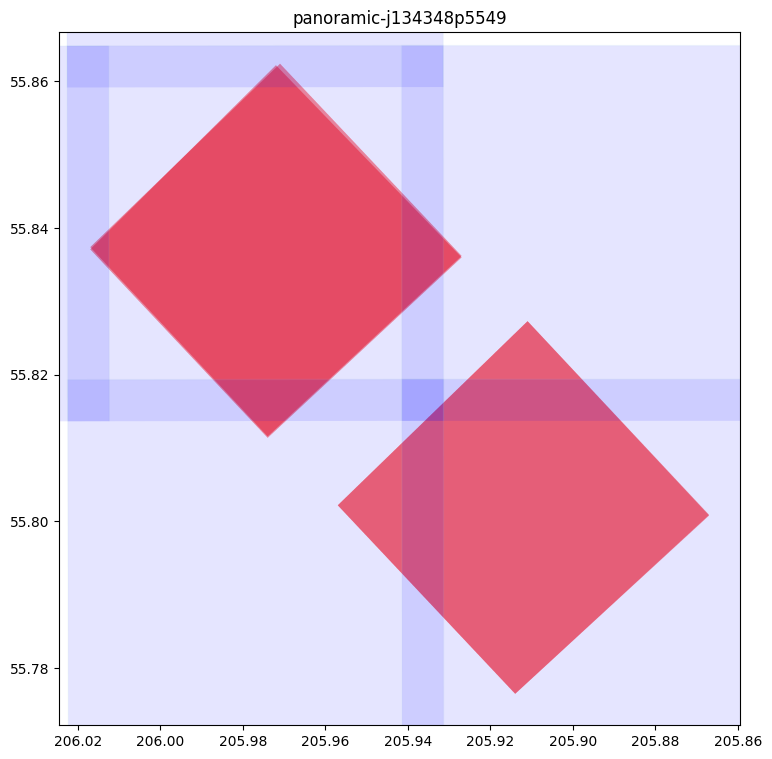

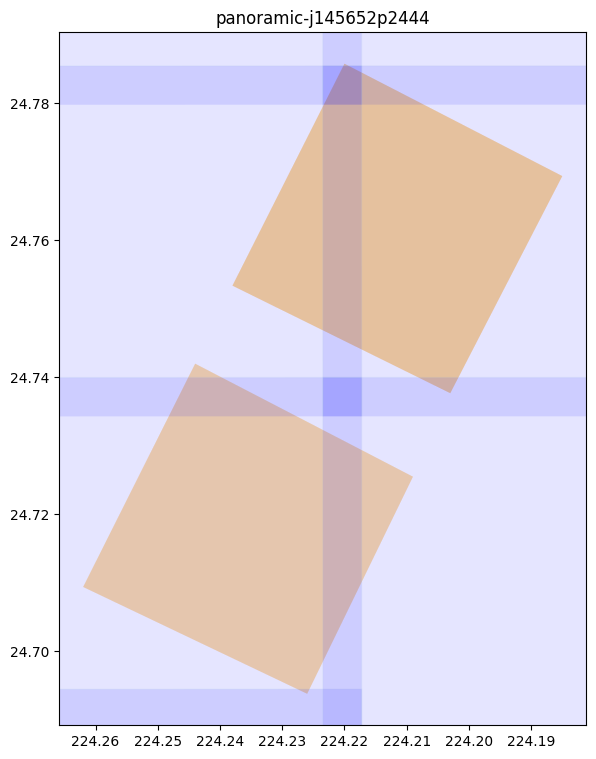

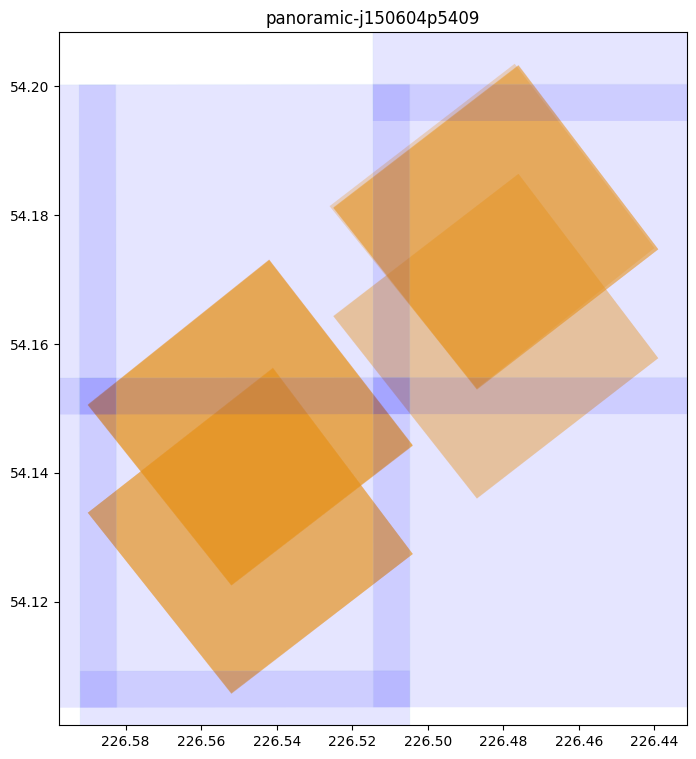

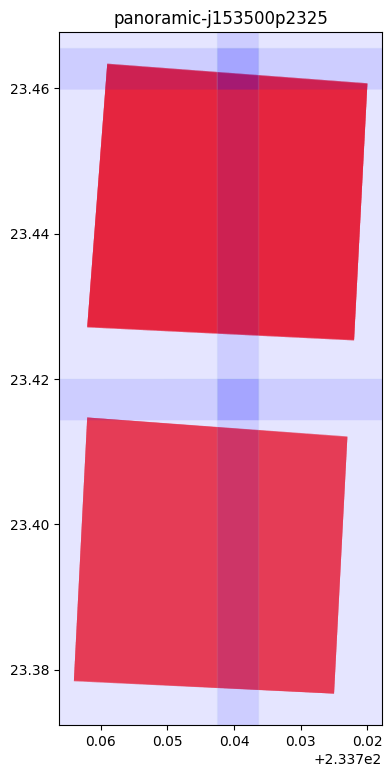

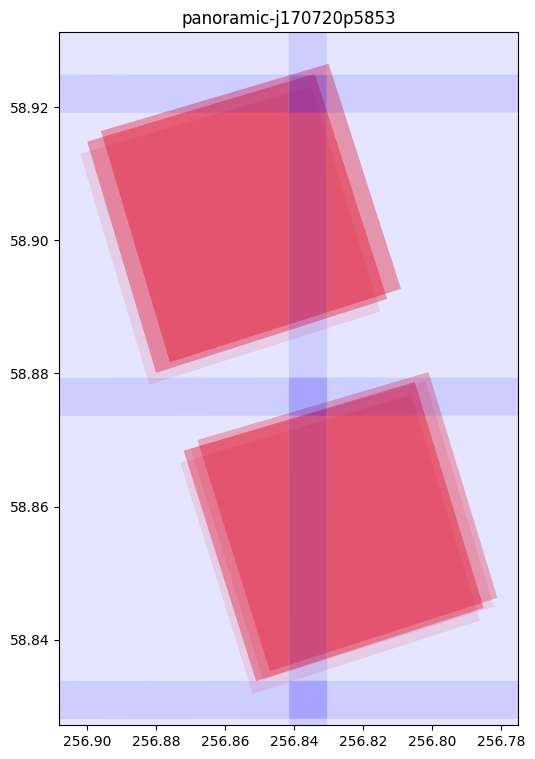

In [12]:
# Make field plots

un = utils.Unique(res['field'])

figs = {}

for v in un.values:
    fig, ax = plt.subplots(1,1,figsize=(9,9))
    test = un[v] & np.in1d(res['filter'], ['F444W-CLEAR'])
    jw_color = 'r'

    if test.sum() == 0:
        test = un[v] & np.in1d(res['filter'], ['F356W-CLEAR'])
        jw_color = 'orange'

    una = utils.Unique(res['assoc'][test], verbose=False)
    for a in una.values:
        for f in res['footprint'][test][una[a]][0::2]:
            sr = utils.SRegion(f)
            ax.scatter(*sr.xy[0][0], alpha=0)
            for p in sr.patch(fc=jw_color, ec='None', alpha=0.1):
                ax.add_patch(p)
        
    figs[v] = fig
    ax.set_title(v)
    cosd = np.cos(ax.get_ylim()[0]/180*np.pi)
    
    ax.set_aspect(1./cosd)
    ax.set_xlim(*ax.get_xlim()[::-1])
    
ftf = ['{field} {tile} {instrume} {filter}'.format(**row) for row in res]
un = utils.Unique(ftf, verbose=False)

ft = ['{field} {tile}'.format(**row) for row in res]
unt = utils.Unique(ft, verbose=False)

for v in unt.values:
    sr = utils.SRegion(res['tile_footprint'][unt[v]][0])
    for p in sr.patch(fc='b', ec='lightblue', alpha=0.1):
        figs[v.split()[0]].axes[0].add_patch(p)
        

In [5]:
# Unique items
gtf = ['{field} {tile} {instrume} {filter}'.format(**row) for row in grp]

ftf = ['{field} {tile} {instrume} {filter}'.format(**row) for row in res]
un = utils.Unique(ftf)

   N  value     
====  ==========
   1  panoramic-j100736p2109 09.08 NIRCAM F200W-CLEAR
   1  panoramic-j100736p2109 09.08 NIRCAM F115W-CLEAR
   1  panoramic-j100736p2109 09.08 NIRCAM F150W-CLEAR
   1  panoramic-j100736p2109 09.08 NIRCAM F277W-CLEAR
   1  panoramic-j170720p5853 09.08 NIRCAM F444W-CLEAR
   1  panoramic-j100736p2109 09.08 NIRCAM F356W-CLEAR
   1  panoramic-j100736p2109 09.08 NIRCAM F444W-CLEAR
   1  panoramic-j100736p2109 08.08 NIRCAM F356W-CLEAR
   1  panoramic-j100736p2109 08.08 NIRCAM F444W-CLEAR
   1  panoramic-j170720p5853 09.08 NIRCAM F356W-CLEAR
   1  panoramic-j170720p5853 09.08 NIRCAM F277W-CLEAR
   1  panoramic-j170720p5853 09.08 NIRCAM F200W-CLEAR
   1  panoramic-j170720p5853 09.08 NIRCAM F115W-CLEAR
   1  panoramic-j170720p5853 09.08 NIRCAM F150W-CLEAR
   1  panoramic-j100736p2109 08.08 NIRCAM F277W-CLEAR
   2  panoramic-j094232p0923 08.08 NIRCAM F444W-CLEAR
   2  panoramic-j100736p2109 08.11 NIRCAM F200W-CLEAR
   2  panoramic-j094232p0923 08.08 NIRCAM F356W-

# Update `combined_tile_filters` table

In [6]:
rows = [v.split() for v in un.values]

tab = utils.GTable(names=['field','tile','instrume','filter'], rows=rows)
tab['modtime'] = 0.
tab['status'] = 0

tab['ndrizim'] = [grp['ndrizim'][gtf.index(v)] for v in un.values]
    
tab

field,tile,instrume,filter,modtime,status,ndrizim
str22,str5,str6,str11,float64,int64,int64
panoramic-j090000p0207,08.09,NIRCAM,F115W-CLEAR,0.0,0,16
panoramic-j090000p0207,08.09,NIRCAM,F150W-CLEAR,0.0,0,16
panoramic-j090000p0207,08.09,NIRCAM,F356W-CLEAR,0.0,0,4
panoramic-j090000p0207,08.09,NIRCAM,F444W-CLEAR,0.0,0,4
panoramic-j090000p0207,08.10,NIRCAM,F115W-CLEAR,0.0,0,20
panoramic-j090000p0207,08.10,NIRCAM,F150W-CLEAR,0.0,0,20
panoramic-j090000p0207,08.10,NIRCAM,F356W-CLEAR,0.0,0,4
panoramic-j090000p0207,08.10,NIRCAM,F444W-CLEAR,0.0,0,4
panoramic-j090000p0207,08.11,NIRCAM,F115W-CLEAR,0.0,0,8


In [7]:
exist = db.SQL("""select * from combined_tiles_filters""")
exist_ftf = ['{field} {tile} {instrume} {filter}'.format(**row) for row in exist]

new_ftf = ['{field} {tile} {instrume} {filter}'.format(**row) for row in tab]

old = np.in1d(new_ftf, exist_ftf)
new = ~old
print(f'ntot: {len(old)}  old: {old.sum()}  new: {(new).sum()}')

ntot: 426  old: 426  new: 0


In [8]:
# Update rows with more exposures now than before
if old.sum() > 0:
    
    for i in np.where(old)[0]:
        new_n = tab['ndrizim'][i]
        j = exist_ftf.index(new_ftf[i])
        old_n = exist['ndrizim'][j]
        cmds = ''
        if new_n != old_n:
            print(f'\n# {new_ftf[i]} {old_n} -> {new_n}')
            cmd = """update combined_tiles_filters
            set status=0, ndrizim={ndrizim}
            where field='{field}' AND tile='{tile}' AND instrume='{instrume}' AND filter= '{filter}';""".format(**tab[i])
            print(cmd)

            if 1:
                db.execute(cmd)
                
        else:
            print(f'OK # {new_ftf[i]} {old_n} -> {new_n}')

        # cmds += cmd
    


OK # panoramic-j090000p0207 08.09 NIRCAM F115W-CLEAR 16 -> 16
OK # panoramic-j090000p0207 08.09 NIRCAM F150W-CLEAR 16 -> 16
OK # panoramic-j090000p0207 08.09 NIRCAM F356W-CLEAR 4 -> 4
OK # panoramic-j090000p0207 08.09 NIRCAM F444W-CLEAR 4 -> 4
OK # panoramic-j090000p0207 08.10 NIRCAM F115W-CLEAR 20 -> 20
OK # panoramic-j090000p0207 08.10 NIRCAM F150W-CLEAR 20 -> 20
OK # panoramic-j090000p0207 08.10 NIRCAM F356W-CLEAR 4 -> 4
OK # panoramic-j090000p0207 08.10 NIRCAM F444W-CLEAR 4 -> 4
OK # panoramic-j090000p0207 08.11 NIRCAM F115W-CLEAR 8 -> 8
OK # panoramic-j090000p0207 08.11 NIRCAM F150W-CLEAR 8 -> 8
OK # panoramic-j090000p0207 08.11 NIRCAM F356W-CLEAR 4 -> 4
OK # panoramic-j090000p0207 08.11 NIRCAM F444W-CLEAR 4 -> 4
OK # panoramic-j090000p0207 09.09 NIRCAM F115W-CLEAR 16 -> 16
OK # panoramic-j090000p0207 09.09 NIRCAM F150W-CLEAR 16 -> 16
OK # panoramic-j090000p0207 09.09 NIRCAM F356W-CLEAR 4 -> 4
OK # panoramic-j090000p0207 09.09 NIRCAM F444W-CLEAR 4 -> 4
OK # panoramic-j090000p0207 

In [9]:
# Send *new* tiles

if (new).sum() > 0:
    print(f'send {new.sum()} new tiles')
    db.send_to_database('combined_tiles_filters', tab[new], if_exists='append')
else:
    print('No new tiles')

No new tiles


# Query `combined_tiles_filters` by status

`combined_tiles_filters.status`
- **0** : to be run
- **1** : in process
- **2** : completed

In [4]:
# Query by status
db.SQL("""select status, count(status) from combined_tiles_filters
group by status order by max(status)""")

status,count
int64,int64
2,3033
10,3


# How many to run?

In [3]:
tile = db.SQL("""SELECT tile, field, filter
              FROM combined_tiles_filters
              WHERE status = 0
              GROUP BY tile, field, filter""")
len(tile)

0

# Launch EC2 instances to drizzle the tiles_filters

In [14]:
import os

def launch_ec2_instances(nmax=50, count=None, filter_tiles=True, templ='lt-0e8c2b8611c9029eb,Version=32'):
    """
    Launch EC2 instances from a launch template that run through all 
    status=0 associations/tiles and then terminate
    
    Version 19 is the latest run_all_visits.sh
    Version 20 is the latest run_all_tiles.sh
    Version 24 is run_all_visits with a new python39 environment
    
    Version 25 is run_all_tile_filters.sh with a new python39 environment
    Version 31 is run_all_tile_filters.sh with a new python39 environment and ImageMagick requirement
    Version 32 is run_all_tile_filters.sh with a new python39 environment and ImageMagick requirement - fix bug
    
    Version 34 is run_all_tiles copied from 32
    Version 35 is run_all_tiles copied from 32, with golfir needed for catalog

    """

    if count is None:
        if filter_tiles:
            assoc = db.SQL("""SELECT tile, field, filter
                      FROM combined_tiles_filters
                      WHERE status = 0
                      GROUP BY tile, field, filter""")
        else:
            templ='lt-0e8c2b8611c9029eb,Version=35'
            
            assoc = db.SQL("""SELECT tile, field
                      FROM combined_tiles
                      WHERE status = 0
                      GROUP BY tile, field""")
            
        count = int(np.minimum(nmax, len(assoc)/2))

    if count == 0:
        print('No associations to run, abort.')
        return True
    else:
        print(f'# {len(assoc)} tiles to run')
        print(f'# Launch {count} instances with LaunchTemplateId={templ}: ')
        cmd = f'aws ec2 run-instances --count {count}'
        cmd += f' --launch-template LaunchTemplateId={templ}'
        print(cmd)
        
        if templ is not None:
            os.system(cmd)

In [17]:
# switch to `if (1) ... ` to run

if (0) & (len(tile) > 0):
    launch_ec2_instances(nmax=80)
else:
    print("Don't launch....")

Don't launch....


In [20]:
## Monitor status - should see some change from 0 -> 1 -> 2, and eventually all 2 (or 10)

db.SQL("""select status, count(status) from combined_tiles_filters
group by status order by max(status)""")

status,count
int64,int64
2,3033
10,3


## Once tiles done by filter, run the combined RGB tiles

`combined_tiles.status`

- **0** : To be run
- **1** : In process
- **2** : Completed
- **3** : The tile has been updated and should be set to zero and run
- **4** : Failed, probably because no overlapping exposures so is fine

In [6]:
db.SQL("""select status, count(status) from combined_tiles
group by status order by status""")

status,count
int64,int64
0,8
1,5
2,1191
4,2089
10,19
90,6101


In [7]:
db.SQL("""select status, count(status) from combined_tiles
group by status order by status""")


status,count
int64,int64
0,8
1,5
2,1191
4,2089
10,19
90,6101


## Change `combined_tiles` status = 3 to 0 and launch EC2 with `run_all_tiles`

In [8]:
# Change status = 3 > 0 and launch 
tiles = db.SQL("""SELECT tile, field
          FROM combined_tiles
          WHERE status in (0,3)
          GROUP BY tile, field""")

if len(tiles) > 0:
    # db.execute
    utils.Unique(tiles['field'])
    
    if (0):
        db.execute('update combined_tiles set status=0 where status=3')

        launch_ec2_instances(nmax=50, count=None, filter_tiles=False,
                             templ='lt-0e8c2b8611c9029eb,Version=35')
    else:
        print("Change logic to execute EC2")
else:
    print('No tiles to reset')

No tiles to reset


In [8]:
# Initial monitor
db.SQL("""select status, count(status) from combined_tiles
group by status order by status""")

status,count
int64,int64
0,8
1,5
2,1191
4,2089
10,19
90,6101


In [38]:
# Monitor
db.SQL("""select status, count(status) from combined_tiles
group by status order by status""")

status,count
int64,int64
1,9
2,1187
4,2089
10,19
90,5820


# Make FITSMap HTML pages.  

Fine to do this while the tiles are running

In [9]:
pano_fields = db.SQL("""select field, count(field) from combined_tiles 
where field like 'panoramic%%'
group by field
order by field
""")

pano_fields

field,count
str22,int64
panoramic-j090000p0207,289
panoramic-j093144p0819,289
panoramic-j093452p6116,289
panoramic-j094232p0923,289
panoramic-j100736p2109,289
panoramic-j121932p0330,289
panoramic-j125652p5652,289
panoramic-j131432p2432,289
panoramic-j134348p5549,289


In [16]:
import astropy.time
import make_fitsmap_html

# First time initializing the file
if False:
    with open('tile_webpages_completed.txt','w') as fp:
        fp.write('# field date time\n')
        for field in pano_fields['field']:
            fp.write(f'{field} {astropy.time.Time.now().iso}\n')

# Run script for fields that need it
done = utils.read_catalog('tile_webpages_completed.txt')

for field in pano_fields['field']:
    if field not in done['field']:
        with open('tile_webpages_completed.txt','a') as fp:
            fp.write(f'{field} {astropy.time.Time.now().iso}\n')
        
        make_fitsmap_html.run_make_fitsmap_html(field)
        

## panoramic-j121932p0330
   N  value     
====  ==========
   8  F115W-CLEAR
   8  F150W-CLEAR
   8  F200W-CLEAR
   8  F277W-CLEAR
   8  F356W-CLEAR
   8  F444W-CLEAR
upload: ./panoramic-j121932p0330_map.html to s3://grizli-v2/ClusterTiles/Map/panoramic-j121932p0330/index.html
https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-j121932p0330/index.html
panoramic-j121932p0330-080-08.08 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j121932p0330-080-08.09 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j121932p0330-080-08.10 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j121932p0330-080-08.11 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j121932p0330-080-09.08 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j121932p0330-080-09.09 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panor

# Now you're done!

Some debugging manual things below.

In [4]:
import make_fitsmap_html

#field = 'panoramic-j100736p2109'
# field = 'panoramic-j150604p5409'
# field = 'panoramic-j094232p0923'

# field = 'panoramic-j090000p0207'
# field = 'panoramic-j093144p0819'
# field = 'panoramic-j093452p6116'
# field = 'panoramic-j094232p0923'
# field = 'panoramic-j125652p5652'
# field = 'panoramic-j145652p2444'
# field = 'panoramic-j153500p2325'
field = 'panoramic-j170720p5853'

# field = 'panoramic-j131432p2432'
# field = 'panoramic-j134348p5549'

## Copy 
make_fitsmap_html.run_make_fitsmap_html(field)

## panoramic-j170720p5853
   N  value     
====  ==========
   8  F115W-CLEAR
   8  F150W-CLEAR
   8  F200W-CLEAR
   8  F277W-CLEAR
   8  F356W-CLEAR
   8  F444W-CLEAR
upload: ./panoramic-j170720p5853_map.html to s3://grizli-v2/ClusterTiles/Map/panoramic-j170720p5853/index.html
https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-j170720p5853/index.html
panoramic-j170720p5853-080-08.08 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j170720p5853-080-08.09 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j170720p5853-080-08.10 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j170720p5853-080-08.11 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j170720p5853-080-09.08 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j170720p5853-080-09.09 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panor

In [5]:
# Testing

import make_fitsmap_html
from importlib import reload

reload(make_fitsmap_html)

field = 'panoramic-j131432p2432'
field = 'panoramic-j170720p5853'

if False:
    for field in pano_fields['field'][:1]:
        make_fitsmap_html.make_vizier_overlay(field)

In [19]:
f_tiles = db.SQL(f"""select * from combined_tiles where field = 'egs-v2'""")
ix = np.argmin(np.abs(f_tiles['crpix1']) + np.abs(f_tiles['crpix2']))
f_tiles[ix]

tile,wcsaxes,crpix1,crpix2,cd1_1,cd2_2,cdelt1,cdelt2,cunit1,cunit2,ctype1,ctype2,crval1,crval2,lonpole,latpole,mjdref,radesys,naxis,naxis1,naxis2,footprint,status,field
str5,int64,float64,float64,float64,float64,float64,float64,str3,str3,str8,str8,float64,float64,float64,float64,float64,str4,int64,int64,int64,str93,int64,str6
12.12,2,128.0,128.0,-2.2222222222222e-05,2.2222222222222e-05,1.0,1.0,deg,deg,RA---TAN,DEC--TAN,214.8288,52.8067333,180.0,52.8067333,0.0,ICRS,2,2304,2304,"((214.833468,52.803911),(214.833474,52.855089),(214.748719,52.855062),(214.748813,52.803884))",2,egs-v2


In [13]:
import make_fitsmap_html
from importlib import reload
reload(make_fitsmap_html)

make_fitsmap_html.make_vizier_overlay('egs-v2', radius=30, ref_tile='10.14')

# egs-v2
     DESI-N (Duncan+22) VII/292/north 0
     DESI-S (Duncan+22) VII/292/south 0
     GAIA DR3 I/355/gaiadr3 2579
     XMM-DR11 (Traulson+22) IX/66/xmm411st 134
Use srcML for source sizes
    * Query XMM-DR12 (Webb+23): IIX/68/xmm4d12s failed
     SDSS DR16Q (Lyke+20) VII/289/superset 2170
     DESI EDR: 1835 sources
     https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/egs-v2/index.html


In [6]:
# Rerun all maps if something changes in the map HTML
import make_fitsmap_html

if False:
    for field in pano_fields['field']:
        make_fitsmap_html.run_make_fitsmap_html(field)
